In [1]:
import os
import argparse
import json
from os import path
from copy import deepcopy

from utils import *

from dataloaders import dataloader_factory
from scheduler.utils import *

from collections import Counter
from tqdm import tqdm

from trainers.utils import recalls_ndcgs_and_mrr_for_ks
from utils import AverageMeter
import gc

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
import matplotlib.pyplot as plt

In [3]:
working_base = "/data03/wushiguang-slurm/projects/recommendation/csrec/code/WSDM-2023-CSRec"

In [4]:
config_path = working_base + "/___el_base/gru4rec/config.json"
data_path = working_base + "/Data/Cache/electronics-5-5.pkl"
base_model_path = working_base + "/___el_base/gru4rec/gru4rec_logs/checkpoint/best_acc_model.pth"
soft_model_path = working_base + "/___el_soft/gru4rec/student_gru4rec_logs/checkpoint/best_acc_model.pth"
ed_model_path = working_base + "/___el_ed/gru4rec/student_gru4rec_logs/checkpoint/best_acc_model.pth"
ep_model_path = working_base + "/___el_ep/gru4rec/student_gru4rec_logs/checkpoint/best_acc_model.pth"
dvae_model_path = working_base + "/___el_dvae/gru4rec/student_gru4rec_logs/checkpoint/best_acc_model.pth"

path_dict = {'base': base_model_path, 'soft': soft_model_path, 'ed': ed_model_path, 'ep': ep_model_path, 'dvae': dvae_model_path}

In [5]:
with open(path.normpath(config_path), 'r') as f:
    args = argparse.Namespace()
    args.__dict__.update(json.load(f))
    if args.kwargs is not None:
        args.__dict__.update(args.kwargs)

args.worker_number=1
args.device='cpu'

In [6]:
train_loader, val_loader, test_loader, dataset = dataloader_factory(args)

item_train, item_valid, item_test, n_users, n_items, rating_train, rating_valid, rating_test = dataset

In [7]:
popularity = Counter()
for user in range(n_users):
    popularity.update(item_train[user])
    popularity.update(item_valid[user])
    popularity.update(item_test[user])

In [8]:
from tqdm import tqdm

def _calculate_batch(batch, model):
    batch = [x.to(args.device) for x in batch]
    
    seqs = batch[0]
    answer = batch[1]
    
    batch_size = seqs.size(0)
    labels = torch.zeros(batch_size, n_items + 1)
    with torch.no_grad():
        scores = model.full_sort_predict(batch)
    
    row = []
    col = []
    
    for i in range(batch_size):
        seq = list(set(seqs[i].tolist()) | set(answer[i].tolist()))
        seq.remove(answer[i][0].item())
        if 0 in seq:
            seq.remove(0)
        labels[i][answer[i]] = 1
        
        row += [i] * len(seq)
        col += seq
    
    scores[row, col] = -1e9
    
    return scores, labels, answer

def calc_metrics(model):
    model.eval()
    
    score_list = []
    label_list = []
    answer_list = []
    
    for batch in test_loader:
        scores, label, answer = _calculate_batch(batch, model)
        score_list.append(scores)
        label_list.append(label)
        answer_list.append(answer)
    
    all_score = torch.cat(score_list)
    all_label = torch.cat(label_list)
    all_answer = torch.cat(answer_list)
    
    return all_score, all_label, all_answer

In [15]:
def get_partial_metrics(interval, answer, score, label, batch_size=512):
    ii = (answer == interval).sum(1)
    score1 = score[ii==1]
    label1 = label[ii==1]
    rating1 = torch.tensor(rating_test)[ii==1]

    average_meter_set = AverageMeterSet()
    
    for s, a, r in zip(score1.split(batch_size), label1.split(batch_size), rating1.split(batch_size)):
        s = s.to('cuda')
        a = a.to('cuda')
        r = r.to('cuda')
        metrics = recalls_ndcgs_and_mrr_for_ks(s, a, [5, 10, 20], r)
        s.to('cpu')
        a.to('cpu')
        r.to('cpu')

        for k, v in metrics.items():
            average_meter_set.update(k, v)
            
#     del score1, label1, rating1

    avg_m = average_meter_set.averages()

    return avg_m

In [16]:
def calculate(answer, score, label, interval, batch_size=1024, interested_metrics='Recall@5'):
    all_m = {}
    for i in range(3):
        avg_m = get_partial_metrics(interval[i], answer, score, label, batch_size=batch_size)
        
        all_m[i] = avg_m

    gc.collect()
    torch.cuda.empty_cache()

    try:
        return [all_m[i][interested_metrics] for i in range(3)]
    except:
        return all_m

In [17]:
def build_intervals(proportion):
    sorted_items = sorted(popularity.keys(), key=lambda x: -popularity[x])
    proportion = [int(np.floor(n_part)) for n_part in np.array(proportion) / sum(proportion) * n_items]
    interval = [torch.tensor(l) for l in np.split(sorted_items, np.cumsum(proportion[:-1]))]
    
    return interval

In [29]:
def ff(proportion_candidates=[[0.5, 3.5, 6]], interested_metrics='Recall@5'):
    figs, axs = plt.subplots(len(proportion_candidates), 5, sharey=True)
    
    for j, (n, p) in enumerate(path_dict.items()):
        model = generate_model(args, args.model_code, dataset, 'cpu')
        load_state_from_given_path(model, p, 'cpu', must_exist=True)

        score, label, answer = calc_metrics(model)
        
        for i, pr in enumerate(proportion_candidates):
            print(n, pr)
            print(answer.size(), score.size(), label.size())
            m = calculate(answer, score, label, build_intervals(pr), interested_metrics=interested_metrics)
            
            if len(proportion_candidates) != 1:
                axs[i, j].bar([1, 2, 3], m, width=1, edgecolor='white', linewidth=0.7)
                axs[i, j].set(xlim=(0, 4), xticks=[1, 2, 3])

                if j == 0:
                    axs[i, j].set_title(f'{pr}, {n}')
                else:
                    axs[i, j].set_title(f'{n}')
            else:
                axs[j].bar([1, 2, 3], m, width=1, edgecolor='white', linewidth=0.7)
                axs[j].set(xlim=(0, 4), xticks=[1, 2, 3])

                if j == 0:
                    axs[j].set_title(f'{pr}, {n}')
                else:
                    axs[j].set_title(f'{n}')
            
            print(m)
        
        del score, label, answer
        gc.collect()
        torch.cuda.empty_cache()

    plt.show()

In [25]:
candidate_partition = [[1, 3, 6], [1, 4, 5], [1, 2, 7], [0.5, 2.5, 7], [0.5, 4.5, 5], [0.1, 2.9, 7]]

base [1, 3, 6]
torch.Size([102187, 1]) torch.Size([102187, 29352]) torch.Size([102187, 29352])
base [1, 4, 5]
torch.Size([102187, 1]) torch.Size([102187, 29352]) torch.Size([102187, 29352])
base [1, 2, 7]
torch.Size([102187, 1]) torch.Size([102187, 29352]) torch.Size([102187, 29352])
base [0.5, 2.5, 7]
torch.Size([102187, 1]) torch.Size([102187, 29352]) torch.Size([102187, 29352])
base [0.5, 4.5, 5]
torch.Size([102187, 1]) torch.Size([102187, 29352]) torch.Size([102187, 29352])
base [0.1, 2.9, 7]
torch.Size([102187, 1]) torch.Size([102187, 29352]) torch.Size([102187, 29352])
soft [1, 3, 6]
torch.Size([102187, 1]) torch.Size([102187, 29352]) torch.Size([102187, 29352])
soft [1, 4, 5]
torch.Size([102187, 1]) torch.Size([102187, 29352]) torch.Size([102187, 29352])
soft [1, 2, 7]
torch.Size([102187, 1]) torch.Size([102187, 29352]) torch.Size([102187, 29352])
soft [0.5, 2.5, 7]
torch.Size([102187, 1]) torch.Size([102187, 29352]) torch.Size([102187, 29352])
soft [0.5, 4.5, 5]
torch.Size([102

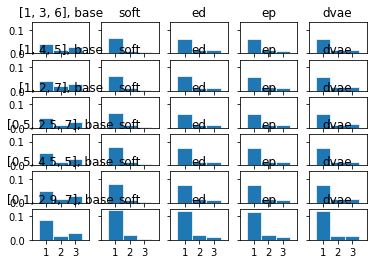

In [26]:
ff(candidate_partition)

base [1, 2, 7]
torch.Size([102187, 1]) torch.Size([102187, 29352]) torch.Size([102187, 29352])
[0.041273372749296516, 0.013966679330105368, 0.02715997569836103]
soft [1, 2, 7]
torch.Size([102187, 1]) torch.Size([102187, 29352]) torch.Size([102187, 29352])
[0.06415489337478693, 0.012203415734288485, 0.005133177834348037]
ed [1, 2, 7]
torch.Size([102187, 1]) torch.Size([102187, 29352]) torch.Size([102187, 29352])
[0.06074693311865513, 0.012980104606274677, 0.013417218596889423]
ep [1, 2, 7]
torch.Size([102187, 1]) torch.Size([102187, 29352]) torch.Size([102187, 29352])
[0.060169812148580186, 0.014116491838965727, 0.012323790731338354]
dvae [1, 2, 7]
torch.Size([102187, 1]) torch.Size([102187, 29352]) torch.Size([102187, 29352])
[0.059607647717572175, 0.013044998636874168, 0.015453834050836472]


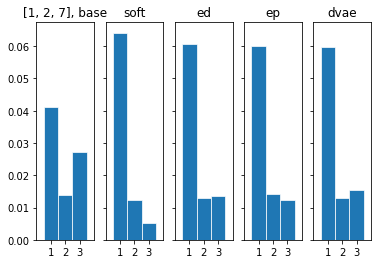

In [30]:
ff([[1, 2, 7]])

In [ ]:
# base_model = generate_model(args, args.model_code, dataset, 'cpu')
# load_state_from_given_path(base_model, base_model_path, 'cpu', must_exist=True)

In [ ]:
# score, label, answer = calc_metrics(base_model)

In [ ]:
# all_m = {}
# for i in range(3):
#     avg_m = get_partial_metrics(interval[i], base_model, batch_size=1024)
    
#     all_m[i] = avg_m

In [ ]:
# ndcg5 = [all_m[i]['Recall@5'] for i in range(3)]

In [ ]:
# fig, ax = plt.subplots()

# ax.bar([1, 2, 3], ndcg5, width=1, edgecolor='white', linewidth=0.7)

# ax.set(xlim=(0, 4), xticks=[1, 2, 3])

# plt.show()